In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

all_data = pd.read_csv('Market_Basket_Optimisation.csv', header=None)
print(all_data.fillna('').to_string(index=False))


                  0                    1                    2                    3                    4                    5                    6                    7                    8                    9                    10                   11               12                   13                   14                15                16              17         18        19
              shrimp              almonds              avocado       vegetables mix         green grapes     whole weat flour                 yams       cottage cheese         energy drink         tomato juice       low fat yogurt            green tea            honey                salad        mineral water            salmon antioxydant juice frozen smoothie    spinach olive oil
             burgers            meatballs                 eggs                                                                                                                                                                          

Данные взята из предложенных варинтов(Вариант №2)
Датасет Market Basket Optimisation представляет собой набор данных о покупках клиентов в магазине. Каждая строка файла соответствует одной транзакции (одному чеку), в которой перечислены товары, купленные вместе. Таким образом, каждая строка — это список продуктов, приобретённых одним покупателем за один раз.

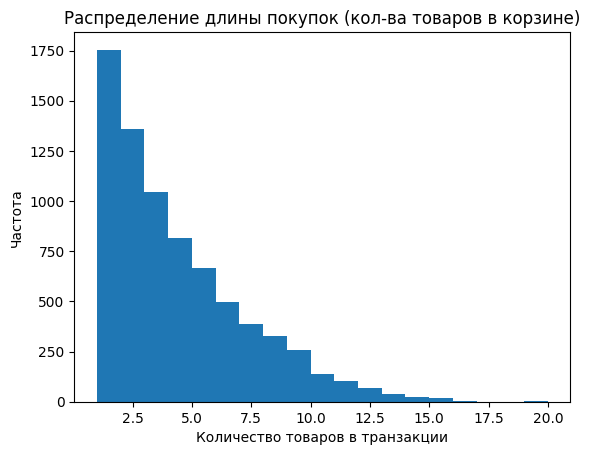

{'shampoo', 'french wine', 'burgers', 'napkins', 'avocado', 'salt', 'brownies', 'strawberries', 'rice', 'candy bars', 'cream', 'butter', 'shrimp', ' asparagus', 'tomato sauce', 'shallot', 'pepper', 'carrots', 'whole weat flour', 'green grapes', 'whole wheat rice', 'yams', 'fresh tuna', 'white wine', 'ham', 'oatmeal', 'green tea', 'french fries', 'dessert wine', 'body spray', 'soup', 'cake', 'chutney', 'flax seed', 'chicken', 'mashed potato', 'protein bar', 'tomatoes', 'babies food', 'barbecue sauce', 'toothpaste', 'asparagus', 'chocolate', 'olive oil', 'sparkling water', 'ketchup', 'spinach', 'low fat yogurt', 'pancakes', 'extra dark chocolate', 'melons', 'yogurt cake', 'mayonnaise', 'energy bar', 'corn', 'nonfat milk', 'gluten free bar', 'cottage cheese', 'escalope', 'light mayo', 'salad', 'green beans', 'almonds', 'herb & pepper', 'ground beef', 'meatballs', 'tomato juice', 'chocolate bread', 'salmon', 'sandwich', 'fromage blanc', 'mushroom cream sauce', 'bacon', 'honey', 'bramble', 

In [14]:
# Анализ транзакций
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Количество товаров в транзакции')
plt.ylabel('Частота')
plt.title('Распределение длины покупок (кол-ва товаров в корзине)')
plt.show()

# Очистка данных
np_data = all_data.to_numpy()
np_data = [[elem for elem in row if isinstance(elem, str)] for row in np_data]

# Список уникальных товаров
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)

На графике изображено распределение количества товаров в покупательской корзине.
Распределение имеет экспоненциальный характер: большинство покупателей приобретают лишь несколько товаров, тогда как длинные транзакции встречаются значительно реже.
Наиболее часто длина покупки составляет от 2 до 6 товаров, что соответствует типичному поведению покупателей при повседневных покупках.

In [15]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

Применяемые алгоритмы принимают на вход бинарную матрицу. Соответствующие элементы равны 1, если товары входят в транзакцию, иначе 0.

In [33]:
df1 = apriori(data, min_support=0.02, use_colnames=True)
print(df1)
rules = association_rules(df1, metric="confidence", min_threshold=0.25)
print(rules)

top_lift = rules.sort_values(by='lift', ascending=False).head(5)
print("\nТоп-5 правил по значению лифта:")
print(top_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

min_lift = rules.sort_values(by='lift', ascending=True).head(5)
print("\nАнти-топ-5 правил по значению лифта:")
print(min_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

      support                           itemsets
0    0.020267                          (almonds)
1    0.033200                          (avocado)
2    0.033733                         (brownies)
3    0.087200                          (burgers)
4    0.030133                           (butter)
..        ...                                ...
99   0.020133  (whole wheat rice, mineral water)
100  0.022933             (olive oil, spaghetti)
101  0.025200              (spaghetti, pancakes)
102  0.021200                (shrimp, spaghetti)
103  0.020933              (tomatoes, spaghetti)

[104 rows x 2 columns]
            antecedents      consequents  antecedent support  \
0             (burgers)           (eggs)            0.087200   
1             (burgers)   (french fries)            0.087200   
2             (burgers)  (mineral water)            0.087200   
3                (cake)  (mineral water)            0.081067   
4             (chicken)  (mineral water)            0.060000   
5   

Применили метод Apriori, задав минимальный уровень поддержки в 2% (в соответствии с вариантом). Таким образом формируется список продуктов (и их комбинаций), встречающихся хотя бы в 2% транзакций. Получено 104 результата. Далее используем функцию association_rules() с метрикой confidence (A ⇒ B) = support(A, B)/support(A), которая берёт только те ассоциативные правила, где вероятность встретить продукт B в транзакции при условии наличия A ≥ 25%.

Важен и показатель lift (A ⇒ B) = confidence(A ⇒ B)/support(B), который показывает, насколько сильнее правило A ⇒ B по сравнению с случайной связью A и B. Правила с lift ≈ 1 будем относить к тривиальным, а правила с lift > 1 — к полезным.

Наиболее полезные правила:
(ground beef) → (spaghetti), lift = 2.291, confidence = 0.399. При покупке ground beef вероятность покупки spaghetti почти 40%, что в 2.3 раза выше случайного совпадения.
(olive oil) → (spaghetti), lift = 2.004, confidence = 0.349. Покупка olive oil повышает вероятность покупки spaghetti в 2 раза.
(soup) → (mineral water), lift = 1.916, confidence = 0.456. soup и mineral water часто покупаются вместе — вероятность почти 46%, что почти в 2 раза выше случайного.

Наиболее тривиальные правила:
(burgers) → (mineral water), lift = 1.174, confidence = 0.280.Покупка burgers не сильно увеличивает вероятность покупки mineral water.
(eggs) → (mineral water), lift = 1.189, confidence = 0.283.
(low fat yogurt) → (mineral water), lift = 1.311, confidence = 0.312.

In [32]:
df1 = apriori(data, min_support=0.03, use_colnames=True)
print(df1)
rules = association_rules(df1, metric="confidence", min_threshold=0.3)
print(rules)

top_lift = rules.sort_values(by='lift', ascending=False).head(5)
print("\nТоп-5 правил по значению лифта:")
print(top_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

min_lift = rules.sort_values(by='lift', ascending=True).head(5)
print("\nАнти-топ-5 правил по значению лифта:")
print(min_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

     support                            itemsets
0   0.033200                           (avocado)
1   0.033733                          (brownies)
2   0.087200                           (burgers)
3   0.030133                            (butter)
4   0.081067                              (cake)
5   0.046800                         (champagne)
6   0.060000                           (chicken)
7   0.163867                         (chocolate)
8   0.080400                           (cookies)
9   0.051067                       (cooking oil)
10  0.031733                    (cottage cheese)
11  0.179733                              (eggs)
12  0.079333                          (escalope)
13  0.170933                      (french fries)
14  0.043067                       (fresh bread)
15  0.063200                   (frozen smoothie)
16  0.095333                 (frozen vegetables)
17  0.052400                     (grated cheese)
18  0.132000                         (green tea)
19  0.098267        

После изменения параметров алгоритма на min_support = 0.03 и confidence = 0.3, количество выбранных частых наборов товаров уменьшилось — теперь рассматриваются только комбинации, встречающиеся хотя бы в 3% транзакций, что позволяет отсечь редкие покупки.
В новом наборе данных прежние наиболее полезные правила, такие как сочетания с высоким lift (например, (ground beef) → (spaghetti)), сохранились, демонстрируя устойчивую связь между ключевыми продуктами. Наибольший lift наблюдается у правила:
(ground beef) → (spaghetti), lift = 2.29, confidence = 0.399
(ground beef) → (mineral water), lift = 1.75, confidence = 0.417
(frozen vegetables) → (mineral water), lift = 1.57, confidence = 0.375
Эти правила показывают сильную взаимосвязь между основными продуктами питания, которые часто покупаются вместе.

Среди менее значимых (но всё ещё полезных) правил можно отметить:
(milk) → (mineral water), lift = 1.55, confidence = 0.37
(pancakes) → (mineral water), lift = 1.49, confidence = 0.355
(spaghetti) → (mineral water), lift = 1.44, confidence = 0.343
Тривиальных правил (с lift ≈ 1 или меньше) на этом уровне поддержки и confidence не обнаружено, так как повышение порога confidence позволило отфильтровать слабые и случайные связи.

In [35]:
df1 = fpgrowth(data, min_support=0.02, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.25)
print(rules)

top_lift = rules.sort_values(by='lift', ascending=False).head(5)
print("\nТоп-5 правил по значению лифта:")
print(top_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

min_lift = rules.sort_values(by='lift', ascending=True).head(5)
print("\nАнти-топ-5 правил по значению лифта:")
print(min_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

      support                          itemsets
0    0.179733                            (eggs)
1    0.087200                         (burgers)
2    0.020933                       (meatballs)
3    0.062533                          (turkey)
4    0.033200                         (avocado)
..        ...                               ...
99   0.020000               (eggs, ground beef)
100  0.020133  (mineral water, frozen smoothie)
101  0.027467             (mineral water, cake)
102  0.027467        (olive oil, mineral water)
103  0.022933            (olive oil, spaghetti)

[104 rows x 2 columns]
            antecedents      consequents  antecedent support  \
0                (eggs)  (mineral water)            0.179733   
1             (burgers)           (eggs)            0.087200   
2             (burgers)  (mineral water)            0.087200   
3             (burgers)   (french fries)            0.087200   
4                (milk)  (mineral water)            0.129600   
5               

Отличий между данными, полученными алгоритмами Apriori и FPG - не наблюдается. Видим полное совпдание.

In [36]:
supports = []
for i in range(0, len(df1['support'])):
    set_len = len(df1['itemsets'][i])
    cur_sup = df1['support'][i]
    if set_len > len(supports):
        supports.append(cur_sup)
    elif supports[set_len - 1] > cur_sup:
        supports[set_len - 1] = cur_sup
print(supports)
print(len(supports))

[np.float64(0.020266666666666665), np.float64(0.02)]
2


Здесь мы вывели минимальный уровень поддержки для составления правил из 1 и 2 продуктов.
В результате анализа видно, что минимальная поддержка для одноэлементных наборов составила 0.02027, а для двухэлементных — 0.02. Это говорит о том, что при текущих параметрах алгоритма Apriori (min_support = 0.02) в данных встречаются только одиночные и парные сочетания товаров.

     support           itemsets
5   0.238267      mineral water
0   0.179733               eggs
14  0.174133          spaghetti
11  0.170933       french fries
20  0.163867          chocolate
6   0.132000          green tea
7   0.129600               milk
33  0.098267        ground beef
15  0.095333  frozen vegetables
29  0.095067           pancakes


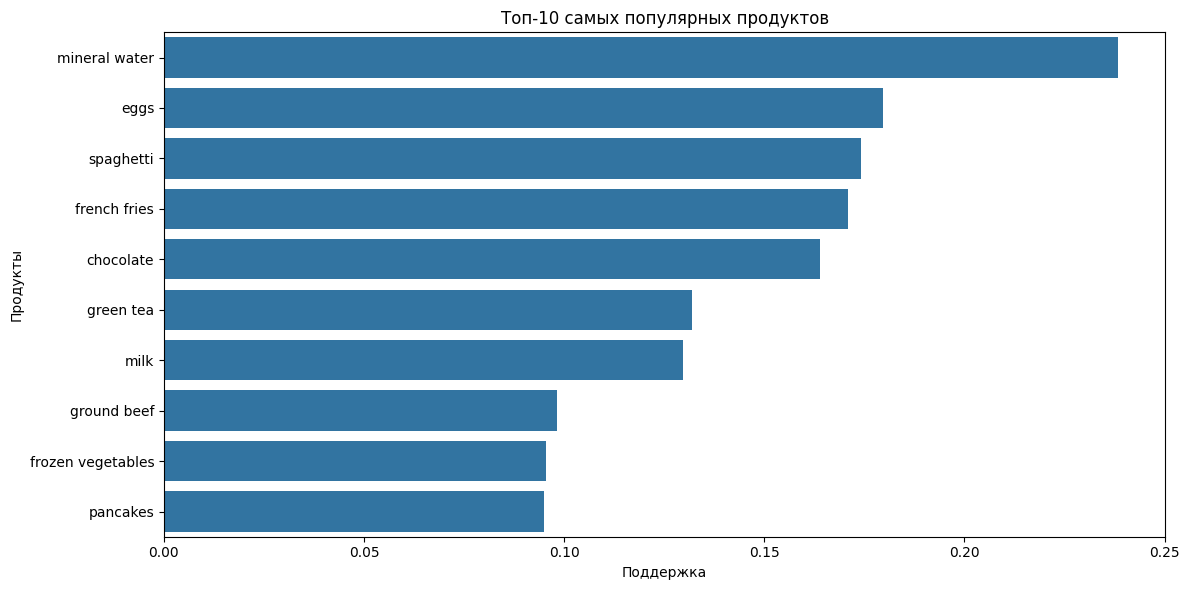

In [37]:
#Поддержка
df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()

Отсортировав продукты по поддержке, видим, что по популярности лидирует минеральная вода, за ней яйца, спагетти и тд.

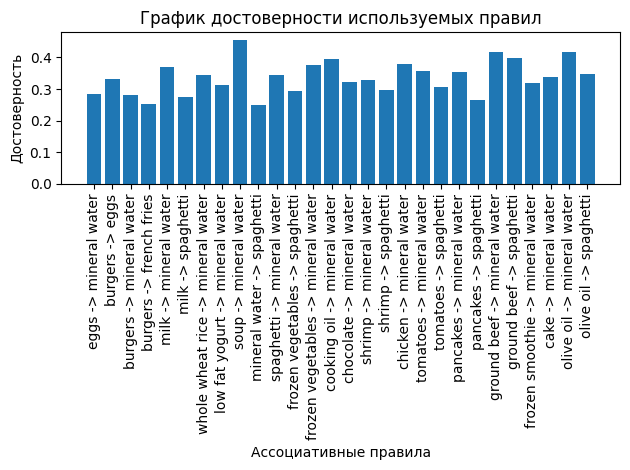

In [38]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
#График достоверности используемых правил
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

График, демонстрирующий значения достоверности, полученные в результате поиска ассоциативных правил.

C:\Users\Максим\AppData\Local\Temp\ipykernel_4192\3501180841.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


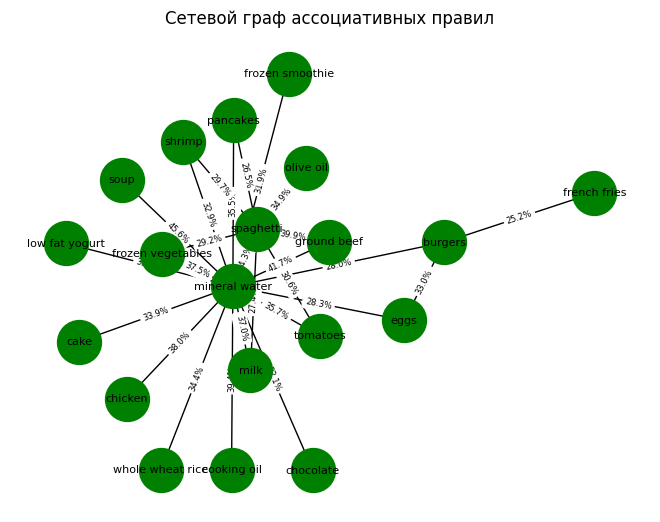

In [41]:
G = nx.Graph()
for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)
for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='green', font_size=8)
edge_labels = {k: f"{v*100:.1f}%" for k, v in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
plt.title('Сетевой граф ассоциативных правил')
plt.tight_layout()
plt.show()

В данном графе узлами являются товары, дуги отражают достоверность. Если мы приобрели торт, то с вероятностью 33.9% мы приобретем минеральную воду.

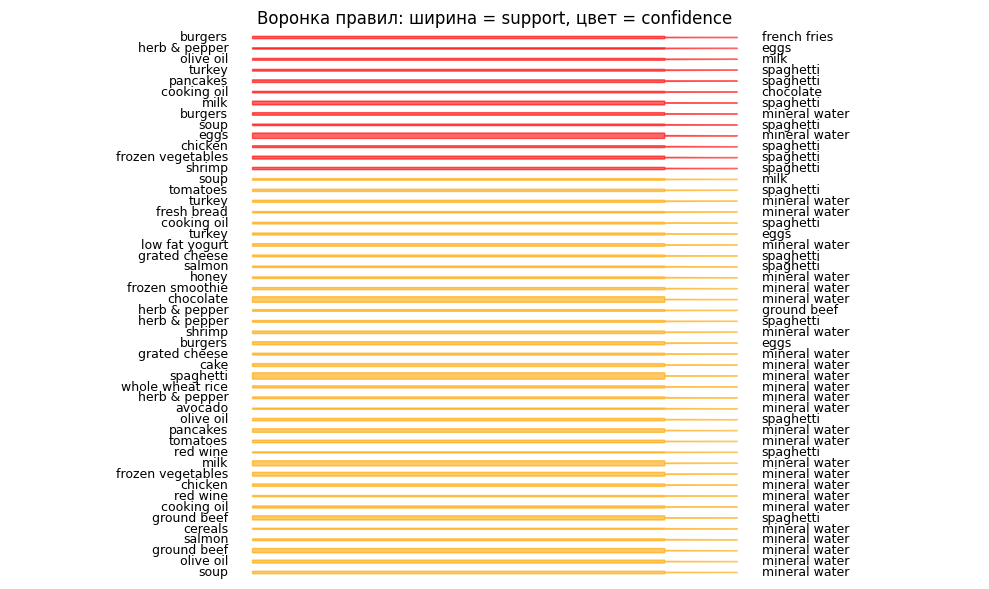

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для выбора цвета по confidence
def conf_color(conf):
    if conf > 0.6:
        return 'green'
    elif conf > 0.3:
        return 'orange'
    else:
        return 'red'

top_rules = rules.sort_values(by='confidence', ascending=False).head(50)
fig, ax = plt.subplots(figsize=(10, 6))

y_positions = np.linspace(0, len(top_rules)*2, len(top_rules))  # равномерные отступы по y

for i, ((_, row), y) in enumerate(zip(top_rules.iterrows(), y_positions)):
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    width = row['support']*20
    color = conf_color(row['confidence'])  # используем функцию
    ax.arrow(0, y, 1, 0, width=width, color=color, alpha=0.6,
             head_width=0.1, length_includes_head=True)
    
    # Подписи антецедента и консеквента
    ax.text(-0.05, y, ant, ha='right', va='center', fontsize=9)
    ax.text(1.05, y, cons, ha='left', va='center', fontsize=9)

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-1, max(y_positions)+1)
ax.axis('off')
plt.title("Воронка правил: ширина = support, цвет = confidence")
plt.tight_layout()
plt.show()


Цвет стрелки отражает достоверность правила (confidence): чем выше confidence, тем стрелка ярче и зелёнее, чем ниже — тем она краснее. Ширина стрелки соответствует support — частоте появления данного правила в данных: толстые стрелки показывают наиболее часто встречающиеся комбинации товаров, тонкие — редкие.
Исходя из диаграммы, можно сделать следующие наблюдения:
Правила с более широкой стрелкой + жёлтой окраской можно рассматривать как относительно надёжные и частые сочетания, например:
chocolate → mineral water
spaghetti → mineral water